In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import TFViTModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_recall_fscore_support
from PIL import Image

In [ ]:
# Define directories for training and validation datasets
train_directory = r'C:\Users\User\Desktop\Class\Dataset\pillimages\train'
validation_directory = r'C:\Users\User\Desktop\Class\Dataset\pillimages\valid'

# Get class labels from the training directory
class_labels = sorted(os.listdir(train_directory))
print(class_labels)

In [ ]:
# Define image size and batch size
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 32

In [19]:
# Set up data generators for training and validation datasets
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [21]:
# Validation data generator without augmentation
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 994 images belonging to 20 classes.
Found 274 images belonging to 20 classes.


In [23]:
# Calculate class weights to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))

In [27]:
# Load the Vision Transformer (ViT) model
vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Define the input layer for the model
input_layer = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), name='image_input')

# Custom Keras layer to wrap the ViT model
@tf.keras.utils.register_keras_serializable()
class ViTLayer(tf.keras.layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        self.vit_model = vit_model

    def get_config(self):
        config = super().get_config()
        config.update({
            'vit_model_name': 'google/vit-base-patch16-224-in21k'
        })
        return config

    @classmethod
    def from_config(cls, config):
        vit_model_name = config.pop('vit_model_name')
        vit_model = TFViTModel.from_pretrained(vit_model_name)
        return cls(vit_model, **config)

    def call(self, inputs):
        processed_inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
        outputs = self.vit_model(pixel_values=processed_inputs).last_hidden_state
        return outputs

# Apply the ViT model to the input
vit_layer = ViTLayer(vit_model)
input_processed = vit_layer(input_layer)
vit_features = Flatten()(input_processed)

# Add fully connected layers for classification
x = vit_features
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Display the model summary
model.summary()

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_layer_1 (ViTLayer)         │ (None, 197, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 151296)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │   154,928,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │        20,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,948,628 (591.08 MB)

 Trainable params: 154,948,628 (591.08 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Set up model checkpoints and early stopping
checkpoint = ModelCheckpoint('medetect_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.1027 - loss: 23.1077 - val_accuracy: 0.4818 - val_loss: 21.9275
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 187s 6s/step - accuracy: 0.3165 - loss: 21.9746 - val_accuracy: 0.6277 - val_loss: 20.8372
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.4338 - loss: 21.0874 - val_accuracy: 0.7117 - val_loss: 20.0396
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accuracy: 0.5170 - loss: 20.3175 - val_accuracy: 0.7555 - val_loss: 19.3421
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accuracy: 0.5545 - loss: 19.6439 - val_accuracy: 0.8029 - val_loss: 18.7092


In [31]:
# Evaluate the model using the validation set
model = tf.keras.models.load_model('medetect_model.keras', custom_objects={'ViTLayer': ViTLayer})
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8056 - loss: 18.7136
Validation loss: 18.709218978881836, Validation accuracy: 0.8029196858406067


In [33]:
# Get predictions for the validation set
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step


In [35]:
# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted', zero_division=0)
print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')

Precision: 0.06334418217629896, Recall: 0.058394160583941604, F1 Score: 0.05794127597160994


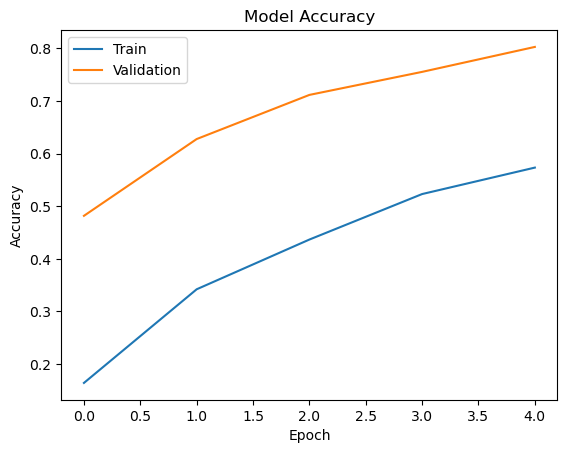

In [37]:
# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

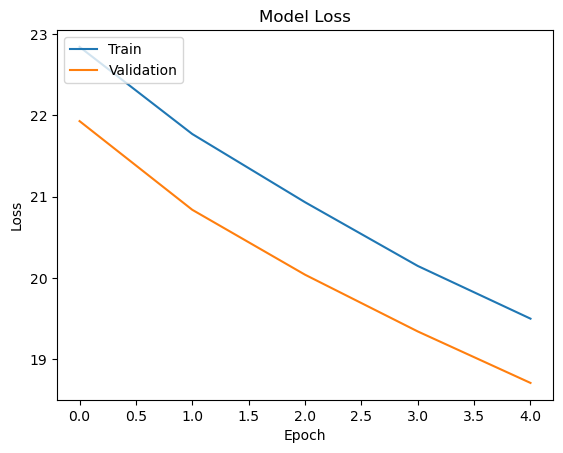

In [39]:
# Plot training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the image to the expected size
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    return img_array

# Function to make a prediction
def predict_image(model, processed_image):
    preds = model.predict(processed_image)
    return preds

# Replace the file upload code
image_path = input("Enter the path to the image file: ")

# Now, proceed with loading, processing, and predicting as before
processed_image = load_and_preprocess_image(image_path)
predictions = predict_image(model, processed_image)

class_names = ['Amoxicillin 500 MG',
               'Atomoxetine 25 MG',
               'Calcitriol 0.00025 MG',
               'Oseltamivir 45 MG',
               'Ramipril 5 MG',
               'apixaban 2.5 MG',
               'aprepitant 80 MG',
               'benzonatate 100 MG',
               'carvedilol 3.125 MG',
               'celecoxib 200 MG',
               'duloxetine 30 MG',
               'eltrombopag 25 MG',
               'montelukast 10 MG',
               'mycophenolate mofetil 250 MG',
               'pantoprazole 40 MG',
               'pitavastatin 1 MG',
               'prasugrel 10 MG',
               'saxagliptin 5 MG',
               'sitagliptin 50 MG',
               'tadalafil 5 MG']

# Get the class with the highest probability
predicted_class = class_names[np.argmax(predictions)]

# Display the image and the prediction label
img = Image.open(image_path)
plt.imshow(img)
plt.text(10, 10, f'Predicted: {predicted_class}', fontsize=12, color='white', backgroundcolor='red')
plt.show()